# Segmentation 모델 구현

<br>

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; U-Net 모델과 U-Net++ 모델의 성능 비교를 수행하였다. 모델 성능 비교를 위해 각 모델의 손실값과 IoU 값을 중심으로 수행하였다. 모델 학습 데이터로는 도로 이미지와 세그멘테이션된 이미지로 구성된 KITTI 데이터셋을 사용하였다. 각 모델의 층은 인코더 4층, 디코더 4층으로 구성되어있으며, 인코더의 필터 수는 64, 128, 256, 512이며, 디코더는 역순이다. 모델 학습은 학습률 1e-4로 설정한 Adam 옵티마이저를 사용하여, 총 100회 수행하였다. U-Net의 최저 손실값은 0.0417이고 이미지 샘플 5개의 IoU값 평균은 0.7578이다. U-Net++의 최저 손실값은 0.0409이고 IoU값 평균은 0.8018이다. U-Net++이 U-Net보다 손실값과 IoU값에 있어 더 좋은 성능을 보임을 확인하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 U-Net 모델과 U-Net++ 모델의 성능 비교를 수행합니다. 모델 성능 비교를 위해 각 모델의 손실값과 IoU 값을 확인합니다. 모델 학습 데이터로는 도로 이미지와 세그멘테이션된 이미지로 구성된 KITTI 데이터셋을 사용합니다. 다음은 본 예제의 목차를 제시한 것입니다.
</span><br><br>

> _1. 데이터셋 생성_
>
> _2. 데이터 전처리 및 데이터 증강_
>
> _3. 모델 생성 및 학습_
>
> _4. 모델 평가_

<br><br>

_**<span style="color:red">※본 예제는 LMS 클라우드가 아닌 로컬에서 진행되어 학습 속도 및 결과 등이 상이할 수 있습니다.</span>**_
***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리 호출
***

In [1]:
import random
import os, math
import numpy as np
from glob import glob

from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as K


from tensorflow.keras import layers, Model, Input
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, Resize

<br>

## 2. 데이터셋 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 학습하기 이전에 주어진 데이터를 분석하고자 합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다.
</span><br><br>
    
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용하는 데이터는 KITTI 데이터셋의 세그멘테이션 데이터셋 입니다. 분석 결과 입력 데이터는 0에서 255 사이의 int8 형식의 도로 이미지와 객체가 세그멘테이션된 이미지로 구성되어있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 네트워크 학습 전, 데이터셋을 네트워크에 입력 가능한 크기로 변경하는 데이터 전처리를 수행합니다. 'KITTI' 데이터셋의 경우, 입력 데이터인 이미지의 크기가 상이하기 때문에, 모든 이미지 크기를 224 × 224로 리사이즈 해주었습니다.
</span>

***

<br>

#### 데이터셋 전처리 함수 정의
***
+ `albumentations`를 이용한 데이터셋 전처리 함수 정의


+ 이미지의 크기를 224 × 224로 리사이즈
***

In [2]:
def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop( 
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(width=224, height=224)
        ])
    
    return Compose([Resize(width=224,height=224)])

<br>

#### 데이터셋 정의 및 생성
***
+ 예제에 사용되는 학습 데이터를 불러온다.


+ 학습 데이터 셋과 검증 데이터 셋 생성
***

In [3]:
class KittiGenerator(K.utils.Sequence):
    def __init__(self,
        dir_path,
        batch_size=4,
        img_size=(224, 224, 3),
        output_size=(224, 224),
        is_train=True,
        augmentation=None
    ):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes
        

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

<br>

#### 데이터셋 샘플 시각화
***
+ KITTI 데이터셋 이미지 시각화

***

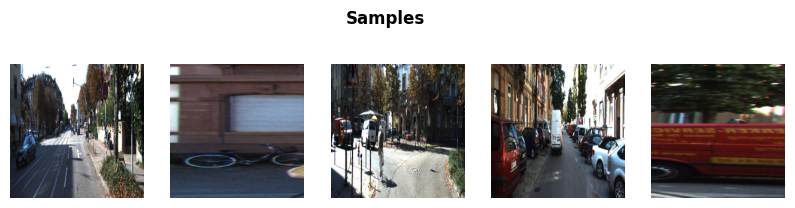

In [4]:
sample_nums = 5


augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(10, 2.5))
plt.suptitle('Samples', fontsize=12, fontweight='bold')
for idx in range(1, sample_nums+1):
    image = imread(input_images[idx])
    image_data = {'image': image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)

    plt.subplot(1, sample_nums, idx)
    plt.axis('off')
    plt.imshow(resized['image'])

plt.show()

<br>

## 3. 모델 구현 및 학습
***

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 'U-Net'과 'U-Net++' 성능을 확인하기 위해, 각 모델의 손실 값을 비교합니다. 손실 함수로 'Binary Cross Entropy' 함수를 이용하였습니다. 학습률 1e-4로 설정하여 'Adam' 옵티마이저를 사용하여 총 100 Epoch 학습하였습니다.
</span>

***

<br>

#### 공통 함수 정의
***
+ U-Net과 U-Net++ 모델에 공통적으로 사용되는 함수 정의

***

In [5]:
class ConvBlock(layers.Layer):
    def __init__(self, input_size: int):
        conv_info = {'activation': 'relu', 'padding': 'same', 'kernel_initializer': 'he_normal'}
        super(ConvBlock, self).__init__()
        
        self.convs = [layers.Conv2D(input_size, kernel_size=3, **conv_info) for _ in range(2)]
        self.batchNorm = layers.BatchNormalization()
        
    def call(self, x):
        out = x
        for conv in self.convs:
            out = conv(out)
        out = self.batchNorm(out)
        return out
    
    
class ConvTBlock(layers.Layer):
    def __init__(self, input_size: int):
        conv_info = {'strides': (2, 2), 'activation': 'relu', 'kernel_initializer': 'he_normal'}
        super(ConvTBlock, self).__init__()        
        
        self.convT = layers.Conv2DTranspose(filters=input_size, kernel_size=2, **conv_info)

    def call(self, x):
        return self.convT(x)
    

class EncBlock(layers.Layer):
    def __init__(self, input_size: int, is_maxpool: bool=True):
        super(EncBlock, self).__init__()
        self.maxpool = None
        if is_maxpool:
            self.maxpool = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv_block = ConvBlock(input_size)
        
    def call(self, x):
        out = x
        if self.maxpool is not None:
            out = self.maxpool(out)
        out = self.conv_block(out)
        return out
    

class DecBlock(layers.Layer):
    def __init__(self, input_size: int):
        super(DecBlock, self).__init__()
        self.upsample = ConvTBlock(input_size)
        self.conv_block = ConvBlock(input_size)
        
        
    def call(self, dec_x, *enc_x):
        dec_x = self.upsample(dec_x)

        out = layers.concatenate([dec_x, *enc_x], axis=3)
        out = self.conv_block(out)
        return out
    
    
class UnetBottleNeck(layers.Layer):
    def __init__(self, input_size: int):
        super(UnetBottleNeck, self).__init__()
        self.conv = ConvBlock(input_size=input_size)
        
    def call(self, x):
        out = x
        enc_out = layers.Dropout(0.5)(out)
        out = layers.MaxPooling2D(pool_size=(2, 2))(enc_out)
        out = self.conv(out)
        dec_out = layers.Dropout(0.5)(out)
        return enc_out, dec_out

<br>

### 3.1. U Net 구현 및 학습

***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; U-Net 모델을 구현하고 학습합니다. 학습률을 1e-4로 설정한 Adam 옵티마이저를 사용하여 총 100회 학습합니다. 검증 데이터셋에 대한 최종 손실값은 0.0533이며, 최저 손실값은 0.0417입니다.
</span>

***


#### U-Net 모델 정의
***
+ 총 파라미터 31,038,725개의 U-Net 모델을 정의

***

In [6]:
class Unet(Model):
    def __init__(self):
        super(Unet, self).__init__()
        
        enc_filters = [64, 128, 256, 512]
        dec_filters = [512, 256, 128, 64]
        
        self.enc_layers = self.__get_ED_layers(filters=enc_filters, block='enc')
        self.bottle_layer = UnetBottleNeck(input_size=1024)
        self.dec_layers = self.__get_ED_layers(filters=dec_filters, block='dec')
        
        self.last_conv1 = layers.Conv2D(
            filters=2, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'
        )
        self.last_conv2 = layers.Conv2D(
            filters=1, kernel_size=1, activation='sigmoid'
        )
        
    def call(self, x):
        out = x
        enc_outs = []
        for idx, layer in enumerate(self.enc_layers):
            out = layer(out)
            if idx < (len(self.enc_layers)-1):
                enc_outs.append(out)

        enc_out, dec_out = self.bottle_layer(out)
        enc_outs.append(enc_out)
        
        for dec_layer, enc_out in zip(self.dec_layers, enc_outs[::-1]):
            dec_out = dec_layer(dec_out, enc_out)

        out = self.last_conv1(dec_out)
        out = self.last_conv2(out)
        return out
    
    def __get_ED_layers(self, filters: list, block: str):
        if block == 'enc':
            layers = [EncBlock(filters[0], False)]
            for size in filters[1:]:
                layers.append(EncBlock(size, True))
            return layers
        
        elif block == 'dec':
            return [DecBlock(size) for size in filters]
        
        print('Default')
        return [DecBlock(size) for size in filters]
    
    def get_summary(self, input_shape=(224, 224, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    

u_model = Unet()
u_model.get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
enc_block (EncBlock)            (None, 224, 224, 64) 38976       input_1[0][0]                    
__________________________________________________________________________________________________
enc_block_1 (EncBlock)          (None, 112, 112, 128 221952      enc_block[0][0]                  
__________________________________________________________________________________________________
enc_block_2 (EncBlock)          (None, 56, 56, 256)  886272      enc_block_1[0][0]                
______________________________________________________________________________________________

<br>

#### U-Net 모델 학습
***
+ 학습률 1e-4의 Adam 옵티마이저를 사용하여 총 100회 학습

***

In [7]:
u_model.compile(optimizer=K.optimizers.Adam(lr=1e-4), loss='binary_crossentropy')

u_his = u_model.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Y:\programFiles\anaconda3\envs\aiffel\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Y:\programFiles\anaconda3\envs\aiffel\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 8s 79ms/step - loss: 0.4295 - val_loss: 0.5894
Epoch 2/100
43/43 [==============================] - 3s 70ms/step - loss: 0.2291 - val_loss: 0.4592
Epoch 3/100
43/43 [==============================] - 3s 69ms/step - loss: 0.1966 - val_loss: 0.4095
Epoch 4/100
43/43 [==============================] - 3s 69ms/step - loss: 0.1781 - val_loss: 0.3513
Epoch 5/100
43/43 [==============================] - 3s 70ms/step - loss: 0.1777 - val_loss: 0.2255
Epoch 6/100
43/43 [==============================] - 3s 69ms/step - loss: 0.1733 - val_loss: 0.1931
Epoch 7/100
43/43 [==============================] - 3s 69ms/step - loss: 0.1618 - val_loss: 0.1852
Epoch 8/100
43/43 [==============================] - 3s 70ms/step - loss: 0.1642 - val_loss: 0.1776
Epoch 9/100
43/43 [==============================] - 3s 70ms/step - loss: 0.1643 - val_loss: 0.1744
Epoch 10/100
43/43 [==============================] - 3s 68ms/step - loss: 0.1628 - val_loss: 0.1748

<br>

### 3.2. U Net++ 구현 및 학습

***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; U-Net++ 모델을 구현하고 학습합니다. 학습률을 1e-4로 설정한 Adam 옵티마이저를 사용하여 총 100회 학습합니다. 검증 데이터셋에 대한 최종 손실값은 0.0464이며, 최저 손실값은 0.0409입니다.
</span>

***


#### U-Net++ 모델 정의
***
+ 총 파라미터 36,165,249개의 U-Net++ 모델을 정의

***

In [7]:
class UppNet(Model):
    def __init__(self):
        super(UppNet, self).__init__()
        enc_filters = [64, 128, 256, 512]
        dec_filters = [512, 256, 128, 64]
        
        self.enc_layers = self.__get_ED_layers(filters=enc_filters, block='enc')
        self.bottle_layer = UnetBottleNeck(input_size=1024)
        self.dec_layers = self.__get_ED_layers(filters=dec_filters, block='dec')
        self.last_conv = layers.Conv2D(1, 1, activation='sigmoid')
        
    def call(self, x):
        out = x
        enc_outs = []
        for idx, layer in enumerate(self.enc_layers):
            out = layer(out)
            if idx < (len(self.enc_layers)-1):
                enc_outs.append(out)

        enc_out, dec_out = self.bottle_layer(out)
        
        
        #Decoder Flow==============================
        enc_outs.extend([enc_out, dec_out])
        
        dec_buff = list()
        enc_li = len(enc_outs) - 1 #enc last idx
        
        for d_i, deep in enumerate(self.dec_layers):
            li = enc_li - d_i #last index
            dec_x, enc_x = enc_outs[li], enc_outs[li-1]
            
            enc_buff = list()
            for w_i, wide in enumerate(deep):
                if w_i == 0:
                    out_d_w = wide(dec_x, enc_x)
                else:
                    out_dP1_w = dec_buff.pop(0)

                    out_d_w = wide(out_dP1_w, enc_x, *enc_buff)

                dec_buff.append(out_d_w)
                enc_buff.append(out_d_w)
        #End=========================================
        
        out = self.last_conv(out_d_w)
        return out

        
    def __get_ED_layers(self, filters: list, block: str):
        layers = []
        if block == 'enc':
            layers = [EncBlock(filters[0], False)]
            for size in filters[1:]:
                layers.append(EncBlock(size, True))
            return layers

        for deep, size in enumerate(filters):
            layers.append(tuple(DecBlock(size) for wide in range(deep+1)))
        return layers
        
        print('Default')
        return layers
    
    def get_summary(self, input_shape=(224, 224, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    

upp_model = UppNet()
upp_model.get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
enc_block_4 (EncBlock)          (None, 224, 224, 64) 38976       input_2[0][0]                    
__________________________________________________________________________________________________
enc_block_5 (EncBlock)          (None, 112, 112, 128 221952      enc_block_4[0][0]                
__________________________________________________________________________________________________
enc_block_6 (EncBlock)          (None, 56, 56, 256)  886272      enc_block_5[0][0]                
____________________________________________________________________________________________

<br>

#### U-Net++ 모델 학습
***
+ 학습률 1e-4의 Adam 옵티마이저를 사용하여 총 100회 학습

***

In [9]:
upp_model.compile(optimizer=K.optimizers.Adam(lr=1e-4), loss='binary_crossentropy')

upp_his = upp_model.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Epoch 1/100
43/43 [==============================] - 13s 178ms/step - loss: 0.6865 - val_loss: 0.6335
Epoch 2/100
43/43 [==============================] - 7s 173ms/step - loss: 0.6100 - val_loss: 0.6157
Epoch 3/100
43/43 [==============================] - 7s 171ms/step - loss: 0.5514 - val_loss: 0.6168
Epoch 4/100
43/43 [==============================] - 7s 172ms/step - loss: 0.4863 - val_loss: 0.4068
Epoch 5/100
43/43 [==============================] - 7s 169ms/step - loss: 0.4235 - val_loss: 0.3195
Epoch 6/100
43/43 [==============================] - 7s 173ms/step - loss: 0.3754 - val_loss: 0.2626
Epoch 7/100
43/43 [==============================] - 7s 170ms/step - loss: 0.3530 - val_loss: 0.3667
Epoch 8/100
43/43 [==============================] - 7s 171ms/step - loss: 0.3242 - val_loss: 0.1724
Epoch 9/100
43/43 [==============================] - 7s 168ms/step - loss: 0.3108 - val_loss: 0.1743
Epoch 10/100
43/43 [==============================] - 7s 169ms/step - loss: 0.3317 - val_l

<br>

## 4. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; U-Net과 U-Net++ 모델을 Adam(learning rate는 1e-4)를 사용하여 총 100회 학습하였습니다. 그 결과, U-Net의 최종 손실값은 0.0533이고 가장 낮은 손실값은 0.0417입니다. U-Net++의 경우 최종 손실값 0.0464이고 최저 손실값은 0.0409입니다. 최종 손실값, 최저 손실값 모두 N-Net++에서 더 낮음을 확인하였습니다. 그림 Loss의 (a)와 (b)는 학습 셋과 검증 셋에 대한 각 모델의 손실 변화를 제시한 것입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이미지 샘플 5개에 대한 각 모델의 IoU 값을 비교하였습니다. 그 결과, 모든 이미지에 대해 U-Net++ 모델의 IoU 값이 높음을 확인하였습니다. 이미지 샘플 5개에 대한 각 모델의 IoU 평균은, U-Net이 0.7578이고 U-Net++가 0.8018입니다.
</span><br><br>

<br>

<center>Table 1. <b>&lt;검증 셋에 대한 최저 손실값 및 IoU 평균></b></center>

||U-Net|U-Net++|
|:---:|:---:|:---:|
|**Loss**|0.0417|**<span style="color:red">0.0409</span>**|
|**IoU**|0.7578|**<span style="color:red">0.8018</span>**|

***

#### 손실값 변화 시각화 함수 정의
***
+ 학습 셋과 검증 셋에 대한 각 모델의 손실값 변화 시각화 함수 정의

***

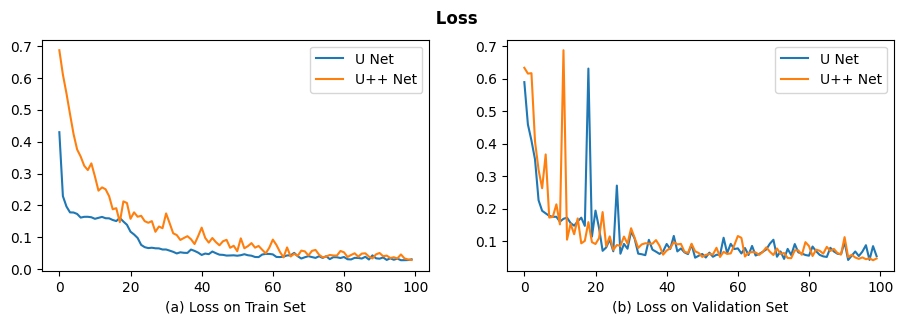

In [10]:
def show_his(u_his, upp_his):
    plt.figure(figsize=(11, 3))
    plt.suptitle(' Loss', fontsize=12, fontweight='bold')
    
    plt.subplot(1, 2, 1)
    plt.plot(u_his.history['loss'], label='U Net')
    plt.plot(upp_his.history['loss'], label='U++ Net')
    plt.legend()
    plt.xlabel('(a) Loss on Train Set', fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(u_his.history['val_loss'], label='U Net')
    plt.plot(upp_his.history['val_loss'], label='U++ Net')
    plt.legend()
    plt.xlabel('(b) Loss on Validation Set', fontsize=10)
    

show_his(u_his=u_his, upp_his=upp_his)

<br>

#### 세그멘트 시각화 및 IoU 출력 함수 정의
***
+ 각 모델의 특정 수의 이미지에 대한 시각화 및 IoU를 출력하는 함수 정의

***

In [11]:
def calculate_iou_score(target, prediction, is_print: bool=False):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    if is_print:
        print('IoU : %f' %iou_score)
    return iou_score

def get_output(model, preproc, image_path: str, label_path: str, is_imshow: bool=False):
    def get_processed(img_path, preproc):
        img = imread(img_path)
        img = {'image': img}
        return preproc(**img)['image']
    
    processed = get_processed(image_path, preproc)
    output = model(np.expand_dims(processed/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1) * 255
    
    origin_img = imread(image_path)
    prediction = output / 255
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    label_processed = get_processed(label_path, preproc)
    target = (label_processed==7).astype(np.uint8) * 1
    
    if is_imshow:
        plt.imshow(output)
    return output, prediction, target

def evaluate(u_model, upp_model, ex_num: int=1, main_path: str='../datasets/gd_08/dataset/training') -> None:
    def get_result(model, x_path, y_path):
        #img와 iou 반환
        output, pred, target = get_output(
            model=model, preproc=test_preproc, image_path=x_path, label_path=y_path, is_imshow=False
        )
        iou = calculate_iou_score(target, pred)
        return output, iou
    
    def imshow(idx, img, txt) -> None:
        write_title = lambda txt: plt.title(txt, fontdict={'fontsize': 10}, loc='left')
        
        plt.subplot(ex_num, 2, idx)
        plt.axis('off')
        plt.imshow(img)
        write_title(txt)
    
    sample_files = random.choices(
        os.listdir(main_path + '/image_2'),
        k=ex_num
    )
    
    plt.figure(figsize=(11, 2*ex_num))
    plt.suptitle('Evaluation', fontsize=12, fontweight='bold')
    
    for idx, file_name in enumerate(sample_files):
        x_path, y_path = main_path + f'/image_2/{file_name}', main_path + f'/semantic/{file_name}'
        
        u_img, u_iou = get_result(model=u_model, x_path=x_path, y_path=y_path)
        upp_img, upp_iou = get_result(model=upp_model, x_path=x_path, y_path=y_path)
        
        imshow(idx=2*idx+1, img=u_img, txt=f'U Net: {u_iou:.3f}')
        imshow(idx=2*(idx+1), img=upp_img, txt=f'U++ Net: {upp_iou:.3f}')

<br>

#### 세그멘트 시각화 및 IoU 출력
***
+ 5개의 랜덤 이미지 샘플에 대한 모델 별 세그멘트 시각화 및 IoU 출력

***

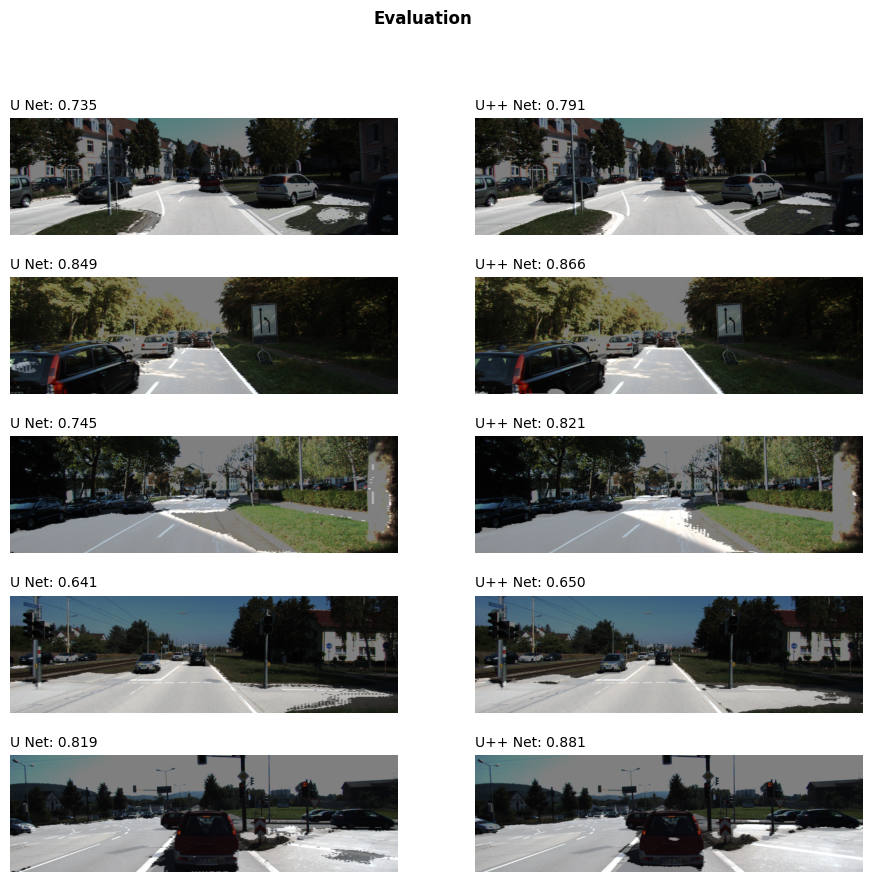

In [14]:
evaluate(u_model=u_model, upp_model=upp_model, ex_num=5)

<br>

## 5. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 U-Net 모델과 U-Net++ 모델의 성능 비교를 수행하였습니다. 성능 비교를 위해 모델의 손실값과 IoU 값을 확인하였습니다. 모델 학습을 위해 KITTI 데이터셋을 사용하였습니다. 학습률 1e-4로 설정한 Adam 옵티마이저로 총 100회 학습하였습니다. 각 모델의 최저 손실값과 IoU 값을 비교한 결과, 두 수치 모두 U-Net++가 양호함을 확인하였습니다.
</span>

***

<br>

#### 형상관리 기록
***
+ v1_1: 초기 예제
***